# Import bibliotek

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import transforms

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from tqdm.auto import tqdm

from typing import List

In [3]:
import sys
sys.path.append("../src/")

from model_builder import HybridModel
from data_setup import create_dataloaders

# Wczytanie danych

In [4]:
df = pd.read_csv("../data/datasets_sum.csv")
df

,Emotion,Path,Dataset,Emotion_mapped
0,ANGRY,../data/kaggle/input/speech-emotion-recognitio...,Crema,0
1,ANGRY,../data/kaggle/input/speech-emotion-recognitio...,Crema,0
2,NEUTRAL,../data/kaggle/input/speech-emotion-recognitio...,Crema,1
3,NEUTRAL,../data/kaggle/input/speech-emotion-recognitio...,Crema,1
4,DISGUST,../data/kaggle/input/speech-emotion-recognitio...,Crema,2
...,...,...,...,...
9390,ANGRY,../data/kaggle/input/speech-emotion-recognitio...,Tess,0
9391,ANGRY,../data/kaggle/input/speech-emotion-recognitio...,Tess,0
9392,ANGRY,../data/kaggle/input/speech-emotion-recognitio...,Tess,0
9393,ANGRY,../data/kaggle/input/speech-emotion-recognitio...,Tess,0


In [5]:
df_crema = df[df["Dataset"]=="Crema"].reset_index(drop=True)
df_ravdess = df[df["Dataset"]=="Ravdess"].reset_index(drop=True)
df_savee = df[df["Dataset"]=="Savee"].reset_index(drop=True)
df_tess = df[df["Dataset"]=="Tess"].reset_index(drop=True)

In [6]:
SAMPLE_RATE = 44100
SEED = 42

In [7]:
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df["Emotion_mapped"], random_state=SEED)

train_df_crema, test_df_crema = train_test_split(df_crema, test_size=0.3, stratify=df_crema["Emotion_mapped"], random_state=SEED)
train_df_ravdess, test_df_ravdess = train_test_split(df_ravdess, test_size=0.3, stratify=df_ravdess["Emotion_mapped"], random_state=SEED)
train_df_savee, test_df_savee = train_test_split(df_savee, test_size=0.3, stratify=df_savee["Emotion_mapped"], random_state=SEED)
train_df_tess, test_df_tess = train_test_split(df_tess, test_size=0.3, stratify=df_tess["Emotion_mapped"], random_state=SEED)

In [8]:
original_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

In [9]:
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dataframe=train_df, 
    test_dataframe=test_df, 
    original_transform=original_transform, 
    augment_transform=augment_transform,
    batch_size=32
)

In [10]:
train_dataloader_crema, test_dataloader_crema, class_names_crema = create_dataloaders(
    train_dataframe=train_df_crema, 
    test_dataframe=test_df_crema, 
    original_transform=original_transform, 
    augment_transform=augment_transform,
    batch_size=32
)

In [11]:
train_dataloader_ravdess, test_dataloader_ravdess, class_names_ravdess = create_dataloaders(
    train_dataframe=train_df_ravdess, 
    test_dataframe=test_df_ravdess, 
    original_transform=original_transform, 
    augment_transform=augment_transform,
    batch_size=32
)

In [12]:
train_dataloader_savee, test_dataloader_savee, class_names_savee = create_dataloaders(
    train_dataframe=train_df_savee, 
    test_dataframe=test_df_savee, 
    original_transform=original_transform, 
    augment_transform=augment_transform,
    batch_size=32
)

In [13]:
train_dataloader_tess, test_dataloader_tess, class_names_tess = create_dataloaders(
    train_dataframe=train_df_tess, 
    test_dataframe=test_df_tess, 
    original_transform=original_transform, 
    augment_transform=augment_transform,
    batch_size=32
)

In [14]:
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x12e02fbc0>,
 array(['DISGUST', 'ANGRY', 'FEAR', 'HAPPY', 'NEUTRAL'], dtype=object))

## Wczytanie modelu

In [15]:
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
device

device(type='mps')

In [16]:
def make_predictions(model: torch.nn.Module,
                     test_dataloader: torch.utils.data.DataLoader, 
                     device: torch.device):
    y_preds = []
    model.eval()
    with torch.inference_mode():
      for X, y in tqdm(test_dataloader, desc="Making predictions"):
        X, y = X.to(device), y.to(device)
          
        y_logit = model(X)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
          
        y_preds.append(y_pred.cpu())
    y_pred_tensor = torch.cat(y_preds)
    return y_pred_tensor

In [17]:
def plot_confusion_matrices(model: torch.nn.Module, 
                            test_dataloaders: List[torch.utils.data.DataLoader], 
                            device: torch.device, 
                            test_dfs: List[pd.DataFrame], 
                            class_names: List[str]):
    num_datasets = len(test_dataloaders)
    
    fig, axes = plt.subplots(1, num_datasets, figsize=(10 * num_datasets, 7))
    
    for i, (test_dataloader, test_df) in enumerate(zip(test_dataloaders, test_dfs)):
        y_pred_tensor = make_predictions(model=model, test_dataloader=test_dataloader, device=device)
        
        test_targets = torch.tensor(test_df["Emotion_mapped"].values)
        confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
        confmat_tensor = confmat(preds=y_pred_tensor, target=test_targets)
        
        ax = axes[i] if num_datasets > 1 else axes
        cax = ax.matshow(confmat_tensor.numpy(), cmap='Blues')
        
        ax.set_xticks(range(len(class_names)))
        ax.set_yticks(range(len(class_names)))
        ax.set_xticklabels(class_names, rotation=45, ha="left")
        ax.set_yticklabels(class_names)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_title(f'Dataset {i+1}: {test_df["Dataset"].values[0]}')
        
        fig.colorbar(cax, ax=ax)

        for (j, k), value in np.ndenumerate(confmat_tensor.numpy()):
            ax.text(k, j, f'{value:.0f}', ha='center', va='center', color='black')

    plt.tight_layout()
    plt.show()

In [18]:
test_dataloaders = [test_dataloader, test_dataloader_crema, test_dataloader_ravdess, test_dataloader_savee, test_dataloader_tess]
test_dfs = [test_df, test_df_crema, test_df_ravdess, test_df_savee, test_df_tess]

### Crema

In [19]:
model_crema = HybridModel(num_emotions=len(class_names_crema))
model_crema.load_state_dict(torch.load(f="../models/cnn_lstm_model_crema.pth"))
model_crema = model_crema.to(device)

Making predictions: 100%|██████████| 19/19 [01:00<00:00,  3.18s/it]


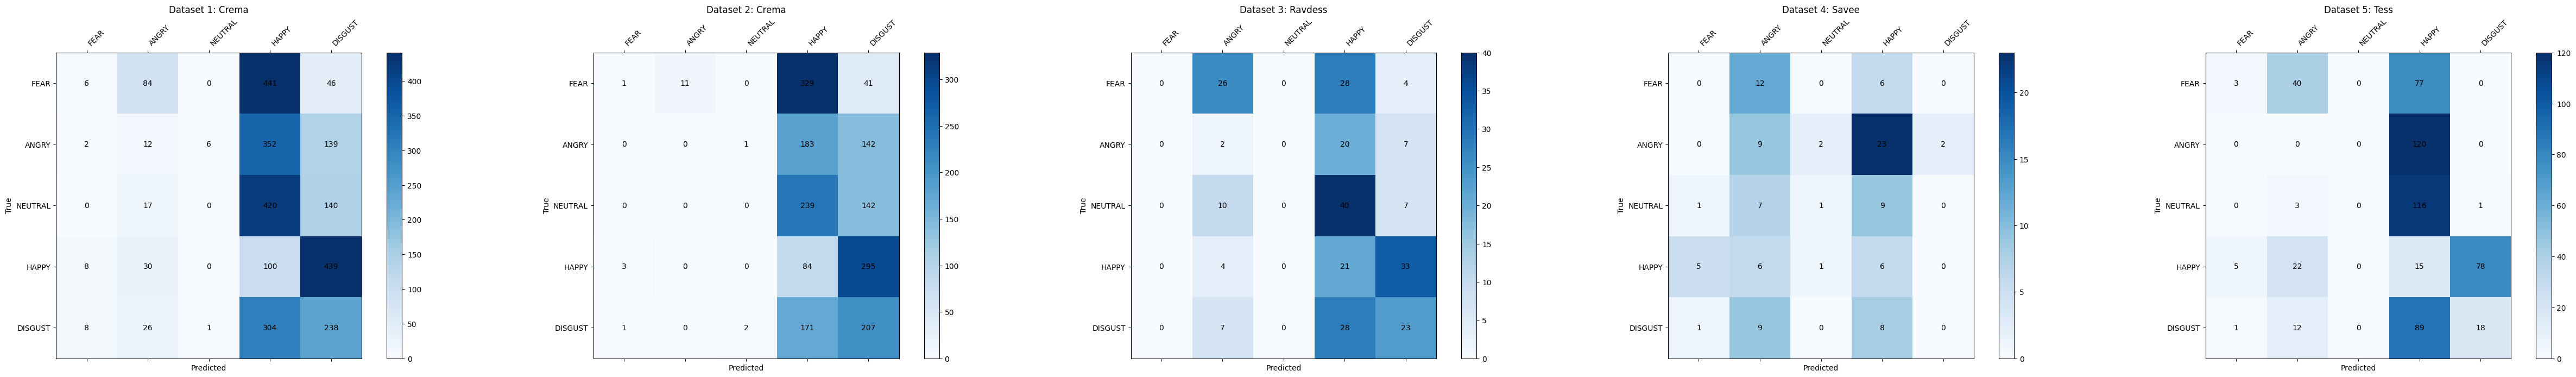

In [20]:
plot_confusion_matrices(model=model_crema, 
                        test_dataloaders=test_dataloaders, 
                        device=device, 
                        test_dfs=test_dfs, 
                        class_names=class_names_crema)

### Ravdess

In [21]:
model_ravdess = HybridModel(num_emotions=len(class_names_ravdess))
model_ravdess.load_state_dict(torch.load(f="../models/cnn_lstm_model_ravdess.pth"))
model_ravdess = model_ravdess.to(device)

Making predictions: 100%|██████████| 19/19 [01:00<00:00,  3.17s/it]


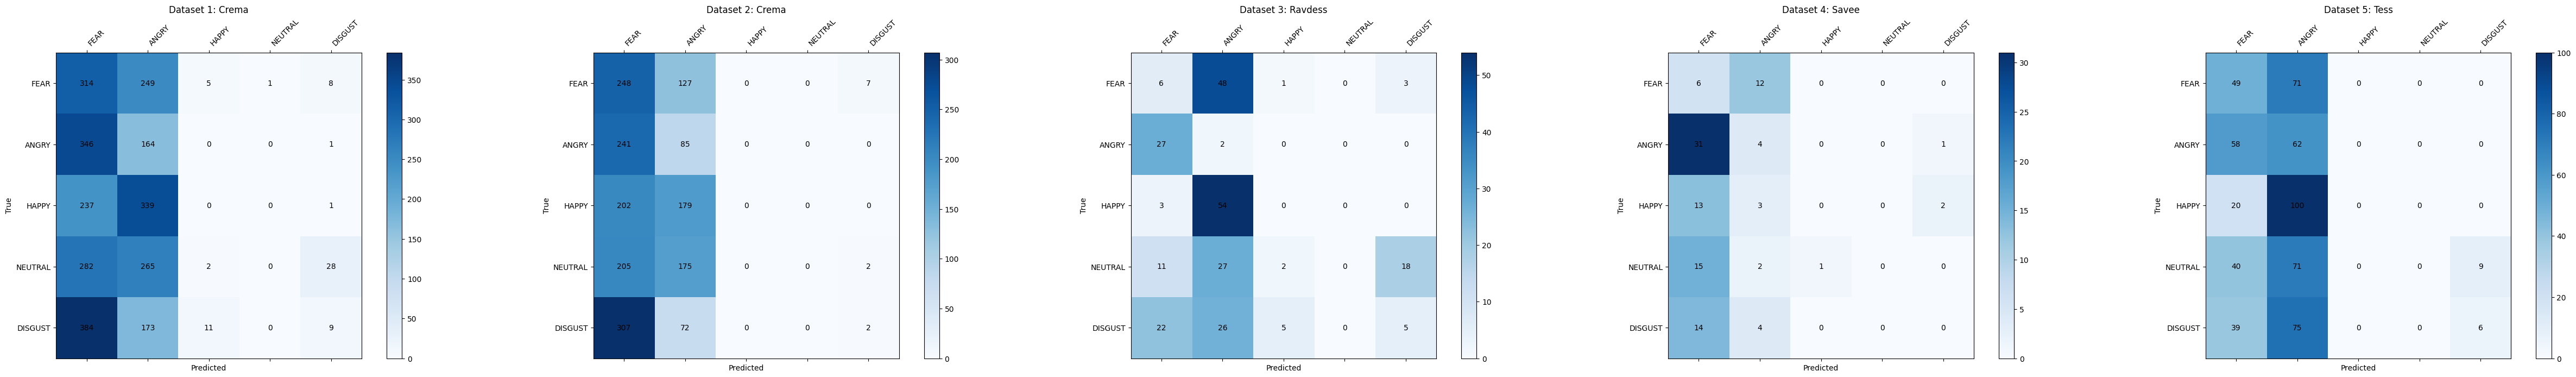

In [22]:
plot_confusion_matrices(model=model_ravdess, 
                        test_dataloaders=test_dataloaders, 
                        device=device, 
                        test_dfs=test_dfs, 
                        class_names=class_names_ravdess)

### Savee

In [23]:
model_savee = HybridModel(num_emotions=len(class_names_savee))
model_savee.load_state_dict(torch.load(f="../models/cnn_lstm_model_savee.pth"))
model_savee = model_savee.to(device)

Making predictions: 100%|██████████| 19/19 [01:00<00:00,  3.16s/it]


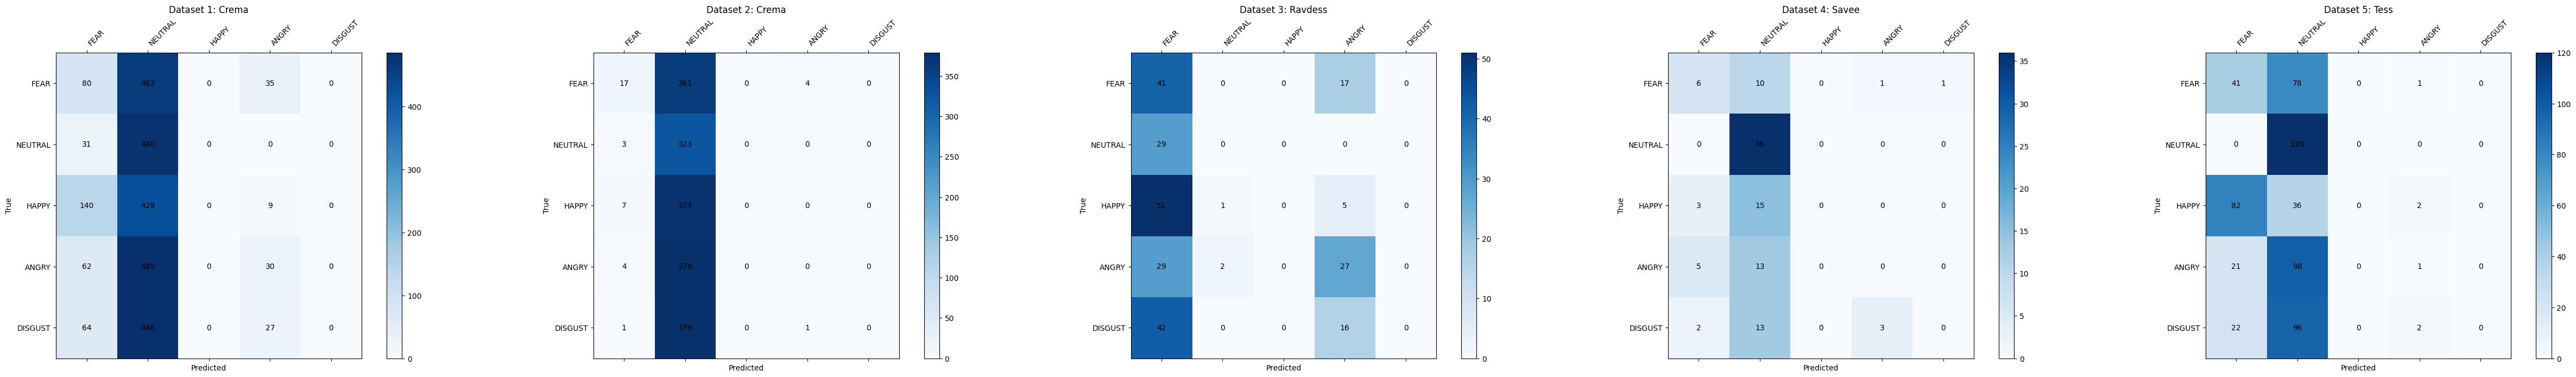

In [24]:
plot_confusion_matrices(model=model_savee, 
                        test_dataloaders=test_dataloaders, 
                        device=device, 
                        test_dfs=test_dfs, 
                        class_names=class_names_savee)

### Tess

In [25]:
model_tess = HybridModel(num_emotions=len(class_names_tess))
model_tess.load_state_dict(torch.load(f="../models/cnn_lstm_model_tess.pth"))
model_tess = model_tess.to(device)

Making predictions: 100%|██████████| 19/19 [01:00<00:00,  3.20s/it]


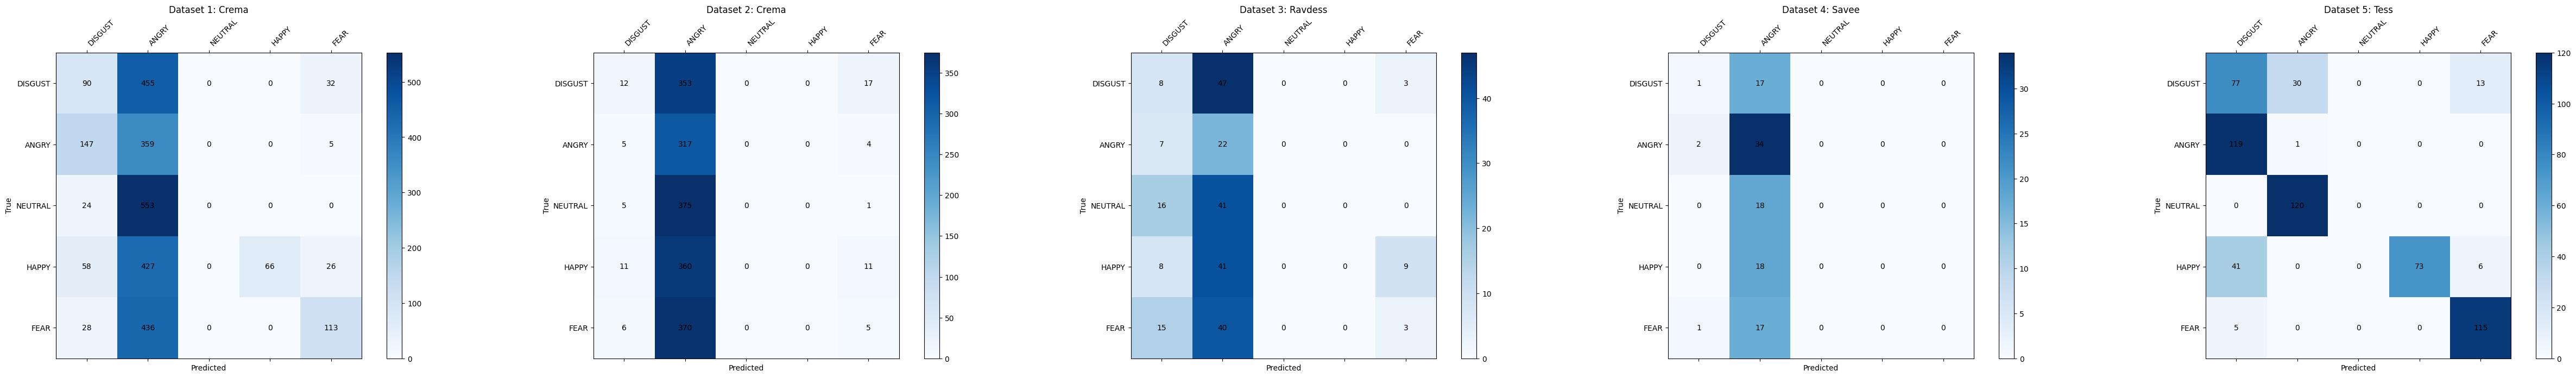

In [26]:
plot_confusion_matrices(model=model_tess, 
                        test_dataloaders=test_dataloaders, 
                        device=device, 
                        test_dfs=test_dfs, 
                        class_names=class_names_tess)

### Datasets combines

In [27]:
model = HybridModel(num_emotions=len(class_names))
model.load_state_dict(torch.load(f="../models/cnn_lstm_model_all.pth"))
model = model.to(device)

Making predictions: 100%|██████████| 19/19 [01:00<00:00,  3.18s/it]


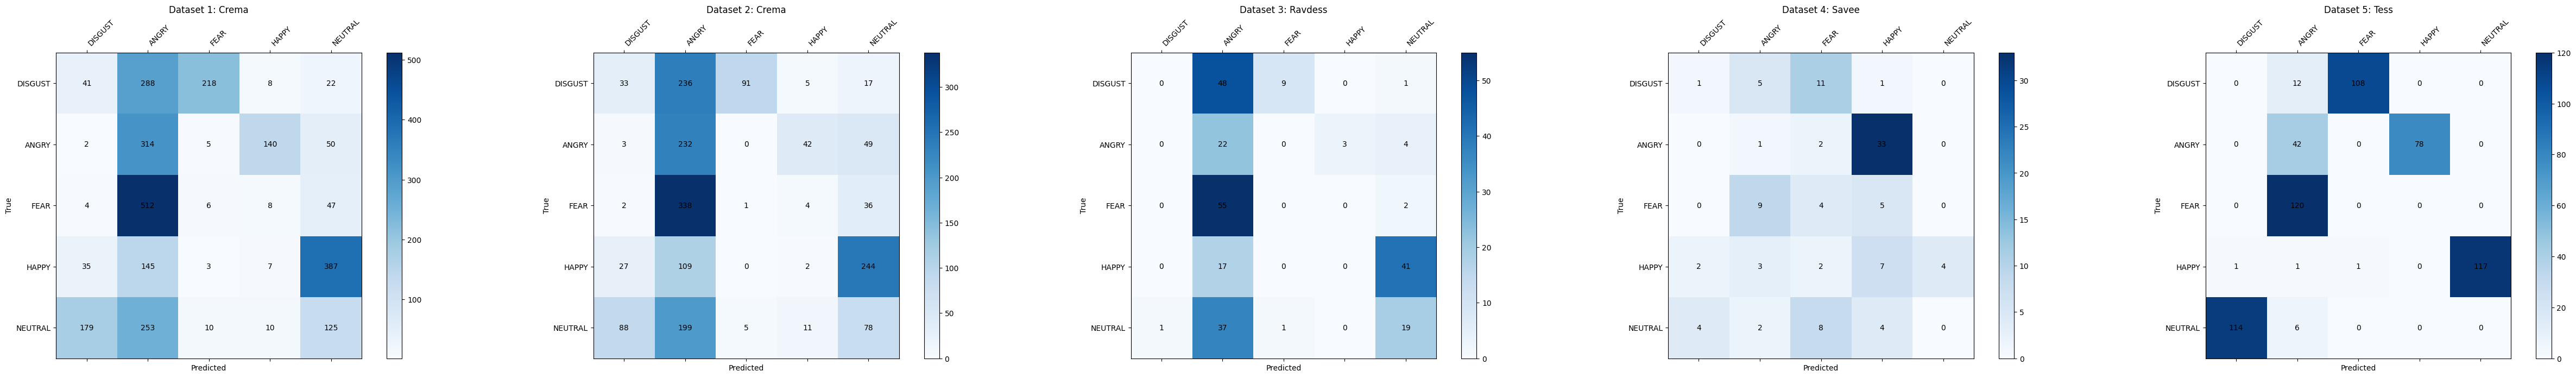

In [28]:
plot_confusion_matrices(model=model, 
                        test_dataloaders=test_dataloaders, 
                        device=device, 
                        test_dfs=test_dfs, 
                        class_names=class_names)